### Importação das bibliotecas

In [1]:
import numpy as np
import pickle as pkl
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPool2D
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2025-02-25 10:55:37.970048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740491737.988812 1115792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740491737.994087 1115792 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 10:55:38.011355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version: 2.18.0
GPU is NOT AVAILABLE


2025-02-25 10:55:41.109665: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-25 10:55:41.109690: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: Debian
2025-02-25 10:55:41.109696: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: Debian
2025-02-25 10:55:41.109791: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.216.1
2025-02-25 10:55:41.109809: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.216.1
2025-02-25 10:55:41.109814: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.216.1


### Listagem de arquivos em diretório com contagem total

In [2]:
filenames = [os.path.join('images', file) for file in os.listdir('images')]
print("Quantidade de imagens na pasta 'images':", len(filenames))

Quantidade de imagens na pasta 'images': 44441


### Carrega o modelo pré-treinado (ResNet50 sem a camada superior)

In [3]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model = tf.keras.models.Sequential([model, GlobalMaxPool2D()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Função para extração e normalização de características de imagem com ResNet50

In [4]:
def extract_features_from_images(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)
    result = model.predict(img_preprocess).flatten()
    norm_result = result / norm(result)
    return norm_result

### Extração de características de todas as imagens do dataset

In [5]:
image_features = []

for file in tqdm(filenames, desc="Extraindo características", total=len(filenames)):
    features = extract_features_from_images(file, model)
    image_features.append(features)

Extraindo características:   0%|          | 0/44441 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

### Serialização e desserialização de características extraídas com Pickle

#### Salvando os dados com pickle

In [6]:
pkl.dump(image_features, open('Images_features.pkl', 'wb'))
pkl.dump(filenames, open('filenames.pkl', 'wb'))

#### Carregando os dados salvos

In [7]:
loaded_features = pkl.load(open('Images_features.pkl', 'rb'))
stored_filenames = pkl.load(open('filenames.pkl', 'rb'))

print("Shape de loaded_features:", np.array(loaded_features).shape)

Shape de loaded_features: (44441, 2048)


### Cria o modelo NearestNeighbors e "treina" (indexa) no conjunto inteiro

In [8]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neighbors.fit(loaded_features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

### Busca por imagens similares usando nearest neighbors

In [18]:
query_image_path = 'consult-images/12817965_0.jpg'
input_image_features = extract_features_from_images(query_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


### Encontra imagens similares

In [19]:
distances, indices = neighbors.kneighbors([input_image_features])
print("Índices das imagens similares:", indices[0])

Índices das imagens similares: [ 5490  9501 18261 11185 26511 32528]


### Mapeia os indices para os caminhos de arquivo

In [20]:
similar_images = [stored_filenames[i] for i in indices[0]]
print("Arquivos das imagens similares:", similar_images)

Arquivos das imagens similares: ['images/26348.jpg', 'images/29491.jpg', 'images/29415.jpg', 'images/40558.jpg', 'images/37506.jpg', 'images/59231.jpg']


### Exibe a imagem de consulta e as similares

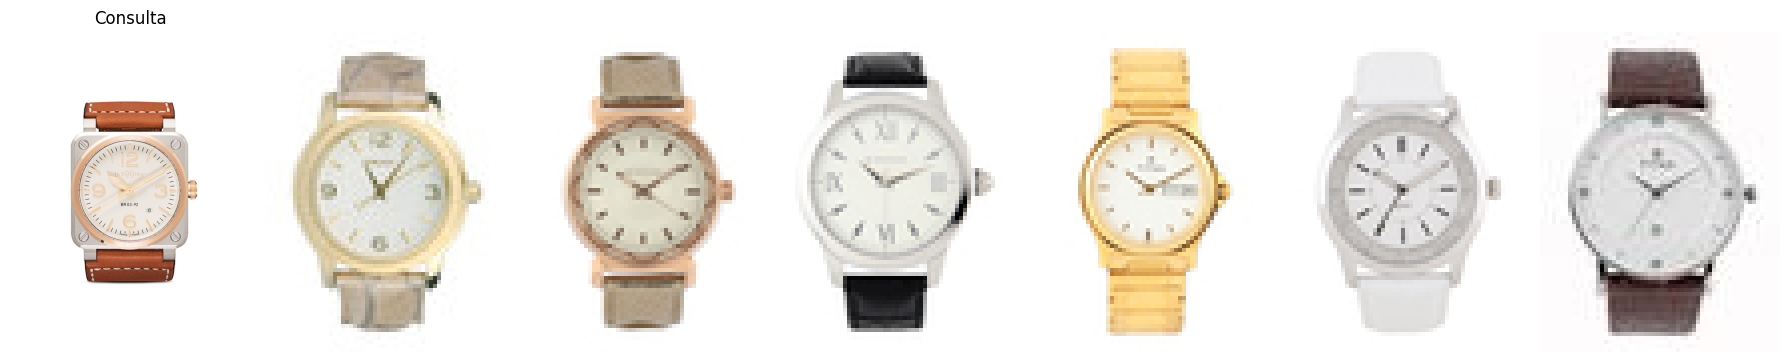

In [21]:
fig, axes = plt.subplots(1, 7, figsize=(18, 5))

# Consulta
query_img = cv2.imread(query_image_path)[:, :, ::-1]
axes[0].imshow(query_img)
axes[0].axis('off')
axes[0].set_title("Consulta", fontsize=12)

# Imagens similares
for ax, img_path in zip(axes[1:], similar_images):
    img = cv2.imread(img_path)[:, :, ::-1]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()